In [1]:
#Importing relevant libraries
from pdfminer.high_level import extract_text
import PyPDF2
from PyPDF2 import PdfReader
import re
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk import download
from gensim import corpora, models
from gensim.models import CoherenceModel
import os
import statistics
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.stats import pearsonr
import matplotlib.pyplot
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from gensim.models.coherencemodel import CoherenceModel


# Download other resources
download('stopwords')
download('punkt')


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/cdlacey/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/cdlacey/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
#Initial stats - file count

def count_files_in_folder(folder_path):
    # Initialize a counter for files
    file_count = 0

    # Walk through the directory and count files
    for _, _, files in os.walk(folder_path):
        file_count += len(files)

    return file_count

folder_path = '/Users/cdlacey/TMU_DataScience/CIND820/Dataset'
total_files = count_files_in_folder(folder_path)
print("Total files in datasource: ", total_files)

Total files in datasource:  1972


In [3]:
#Initial stats - page count

def count_pages_and_stats(folder_path):
    total_pages = 0
    page_counts = []

    for filename in os.listdir(folder_path):
        if filename.endswith('.pdf'):
            file_path = os.path.join(folder_path, filename)
            with open(file_path, 'rb') as file:
                pdf_reader = PdfReader(file)
                num_pages = len(pdf_reader.pages)
                total_pages += num_pages
                page_counts.append(num_pages)

    mean_page_count = statistics.mean(page_counts)
    median_page_count = statistics.median(page_counts)

    return total_pages, mean_page_count, median_page_count

folder_path = '/Users/cdlacey/TMU_DataScience/CIND820/Dataset'
total_pages, mean_page_count, median_page_count = count_pages_and_stats(folder_path)

print("Total pages in all PDF files:", total_pages)
print("Mean page count per file:", mean_page_count)
print("Median page count per file:", median_page_count)

Total pages in all PDF files: 155385
Mean page count per file: 78.8756345177665
Median page count per file: 80.0


In [4]:
#Setting up to extract text from PDF function

def extract_text_from_pdf(pdf_file):
    text = ""
    with open(pdf_file, 'rb') as file:
        reader = PyPDF2.PdfReader(file)
        num_pages = len(reader.pages)
        for page_num in range(num_pages):
            page = reader.pages[page_num]
            text += page.extract_text()
    return text

In [5]:
# Setting up the function to extract the Parliament-Session information

def extract_parliament_session(text):
    # Finding the Parliament and Session numbers in each document
    parliament_match = re.search(r'(\d+)(?:st|nd|rd|th) PARLIAMENT', text)
    session_match = re.search(r'(\d+)(?:st|nd|rd|th) SESSION', text)

    # Formating the Parliament-Session value
    if parliament_match and session_match:
        parliament = parliament_match.group(1)
        session = session_match.group(1)
        parliament_session = f"{parliament}-{session}"
        return parliament_session
    else:
        return None

In [6]:
#preprocessing all documents in dataset, removing stopwords and other characters

def preprocess_text(text):
    # Tokenize
    tokens = word_tokenize(text)
    # Remove punctuation and convert to lowercase
    tokens = [token.lower() for token in tokens if token not in string.punctuation]
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    french_stopwords = set(stopwords.words('french'))
    stop_words.update(french_stopwords)
    # Remove numbers, symbols, and certain words
    tokens = [re.sub(r'[^a-zA-Z]', '', token) for token in tokens]
    tokens = [token for token in tokens if token and token not in stop_words]
    # Remove specific words or letters which are not useful
    additional_stopwords = {
        'mr.', 'mr', 'mrs.', 'ms.', 'speaker', 'bill', 'debate', 'hon', 'cpc', 'lib', 'bq', 'canadian', 
        'act', 'amend', 'amendment', 'canada', 'house', 'public', 'honour', 'minister', 'ministry', 'govern', 
        'member', 'program', 'primeminister', 'would', 'people', 'chair', 'committe', 'liber', 'polici', 'parliamentari', 
        'ndp', 'government', 'conserv', 'parties', 'partisan', 's', 'b', 'c', 'e', 'f', 'g', 'h', 'j', 'k', 'l', 'm', 'n', 'o', 'p',
        'q', 'r', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'am', 'pm','year','time','motion','go', 'canadians', 
        'also', 'members', 'madam', 'committee', 'prime', 'senate', 'senator', 'hous',
        'one', 'govern', 'liberal', 'conservative', 'liberals', 'conservatives', 'speech', 'parliamentarian',
        'secretariat', 'ii', 'iii', 'iv', 'v', 'vi', 'vii', 'viii', 'ix', 'x', 'xi', '000', '1', '3', '5', '11', 
        '15', '22', '25', '2007', '2008', '2009', '2010', '2011',
        '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022', '2023', '‚Äô',
        '‚Äú', '‚Äù', "’",'...................',' ................................................',
        '........',"'s"}
    tokens = [token for token in tokens if token not in additional_stopwords]
    # Stemming
    stemmer = PorterStemmer()
    tokens = [stemmer.stem(token) for token in tokens]
    return tokens

In [7]:
#Setting up LDA model using corpus

def perform_topic_modeling(documents, num_topics=7):
    dictionary = corpora.Dictionary(documents)
    corpus = [dictionary.doc2bow(doc) for doc in documents]
    lda_model = models.LdaModel(corpus, num_topics=num_topics, id2word=dictionary)
    return lda_model, dictionary

In [8]:
#Extracting text from all documents, setting up initial dataframe
#This is processor heavy given the size of dataset. It may take some time (1 hour or longer)
#function set up to create an attribute list of data and metadata including:
#document name, parliament & session values, dominant topics, topic keywords, word counts, and coherance values

# Define PDF directory
pdf_directory = '/Users/cdlacey/TMU_DataScience/CIND820/Dataset'

# Initialize data dictionary for structured output
data = {'Document': [], 'Parliament-Session': [], 'Dominant Topic': [], 'Topic Keywords': [], 'Preprocessed Tokens': [], 'Original Word Count': [], 'Final Word Count': [], 'Topic Coherence': []}

# Iterate over PDF files in the directory
for filename in os.listdir(pdf_directory):
    if filename.endswith('.pdf'):
        pdf_file = os.path.join(pdf_directory, filename)
        text = extract_text_from_pdf(pdf_file)  # Extract text from PDF
        original_word_count = len(text.split())  # Count original words before preprocessing
        preprocessed_text = preprocess_text(text)  # Preprocess the extracted text
        final_word_count = len(preprocessed_text)  # Count final words after preprocessing
        # Call perform_topic_modeling to generate LDA model and dictionary
        lda_model, dictionary = perform_topic_modeling([preprocessed_text])
        coherence_model_lda = CoherenceModel(model=lda_model, texts=[preprocessed_text], dictionary=dictionary, coherence='c_v')
        coherence_lda = coherence_model_lda.get_coherence()
        doc_bow = dictionary.doc2bow(preprocessed_text)
        doc_topics = lda_model.get_document_topics(doc_bow)
        dominant_topic = max(doc_topics, key=lambda x: x[1])[0]
        topic_keywords = lda_model.show_topic(dominant_topic)
        parliament_session = extract_parliament_session(text)  # Extract Parliament-Session
        data['Document'].append(filename)
        data['Parliament-Session'].append(parliament_session)
        data['Dominant Topic'].append(dominant_topic)
        data['Topic Keywords'].append(', '.join([word for word, _ in topic_keywords]))
        data['Preprocessed Tokens'].append(preprocessed_text)
        data['Original Word Count'].append(original_word_count)
        data['Final Word Count'].append(final_word_count)
        data['Topic Coherence'].append(coherence_lda)

# Create a DataFrame from the structured data
df = pd.DataFrame(data)
print(df.head())

                Document Parliament-Session  Dominant Topic  \
0  20170130-HAN129-E.pdf               42-1               6   
1  20200420-HAN034-E.pdf               43-1               6   
2  20230602-HAN205-E.pdf               44-1               2   
3  20120307-HAN091-E.pdf               41-1               4   
4  20131126-HAN024-E.pdf               41-2               2   

                                      Topic Keywords  \
0  regard, statist, mani, question, inform, retur...   
1  work, busi, need, help, mani, support, health,...   
2  point, order, question, mr, assist, deputi, ca...   
3  job, countri, know, want, debat, last, english...   
4  question, say, duffi, know, parti, ask, talk, ...   

                                 Preprocessed Tokens  Original Word Count  \
0  [common, debat, volum, number, st, session, nd...                94682   
1  [rd, parliament, st, session, common, debat, o...                74492   
2  [th, parliament, st, session, common, debat, o... 

In [9]:
#pulling date information for each document to add to df

df['Date'] = pd.to_datetime(df['Document'].str[:8], format='%Y%m%d')

In [10]:
print(df.columns)

Index(['Document', 'Parliament-Session', 'Dominant Topic', 'Topic Keywords',
       'Preprocessed Tokens', 'Original Word Count', 'Final Word Count',
       'Topic Coherence', 'Date'],
      dtype='object')


In [11]:
new_cols = ["Document","Date","Parliament-Session", "Dominant Topic","Topic Keywords","Preprocessed Tokens", "Original Word Count", "Final Word Count", "Topic Coherence"]
df = df.reindex(columns=new_cols)
print(df.head())

                Document       Date Parliament-Session  Dominant Topic  \
0  20170130-HAN129-E.pdf 2017-01-30               42-1               6   
1  20200420-HAN034-E.pdf 2020-04-20               43-1               6   
2  20230602-HAN205-E.pdf 2023-06-02               44-1               2   
3  20120307-HAN091-E.pdf 2012-03-07               41-1               4   
4  20131126-HAN024-E.pdf 2013-11-26               41-2               2   

                                      Topic Keywords  \
0  regard, statist, mani, question, inform, retur...   
1  work, busi, need, help, mani, support, health,...   
2  point, order, question, mr, assist, deputi, ca...   
3  job, countri, know, want, debat, last, english...   
4  question, say, duffi, know, parti, ask, talk, ...   

                                 Preprocessed Tokens  Original Word Count  \
0  [common, debat, volum, number, st, session, nd...                94682   
1  [rd, parliament, st, session, common, debat, o...            

In [12]:
#To support future analysis, splitting the values in the "Topic Keywords" column and expand them into separate columns
df_keywords = df['Topic Keywords'].str.split(', ', expand=True)

# Assigning names to each Topic Keyword column
df_keywords.columns = [f'Topic Keyword {i}' for i in range(len(df_keywords.columns))]

#adding the new columns with the original DataFrame
df = pd.concat([df, df_keywords], axis=1)

print(df.head())

                Document       Date Parliament-Session  Dominant Topic  \
0  20170130-HAN129-E.pdf 2017-01-30               42-1               6   
1  20200420-HAN034-E.pdf 2020-04-20               43-1               6   
2  20230602-HAN205-E.pdf 2023-06-02               44-1               2   
3  20120307-HAN091-E.pdf 2012-03-07               41-1               4   
4  20131126-HAN024-E.pdf 2013-11-26               41-2               2   

                                      Topic Keywords  \
0  regard, statist, mani, question, inform, retur...   
1  work, busi, need, help, mani, support, health,...   
2  point, order, question, mr, assist, deputi, ca...   
3  job, countri, know, want, debat, last, english...   
4  question, say, duffi, know, parti, ask, talk, ...   

                                 Preprocessed Tokens  Original Word Count  \
0  [common, debat, volum, number, st, session, nd...                94682   
1  [rd, parliament, st, session, common, debat, o...            

In [13]:
# Identify and retrieve the text based on the dominant topic number
def get_dominant_topic_value(row):
    # Extract the dominant topic value from the 'Dominant Topic' column
    dominant_topic = row['Dominant Topic']
    # Extract the corresponding text from the 'Topic Keyword' columns based on the dominant topic
    topic_keyword_column = f'Topic Keyword {dominant_topic}'
    return row[topic_keyword_column]

# adding a new column 'Dominant Topic Value' to df
df['Dominant Topic Value'] = df.apply(get_dominant_topic_value, axis=1)

In [14]:
new_cols = ["Document","Date","Parliament-Session", "Original Word Count", "Final Word Count", "Topic Coherence", "Dominant Topic", "Dominant Topic Value", "Topic Keywords", "Topic Keyword 0","Topic Keyword 1","Topic Keyword 2","Topic Keyword 3","Topic Keyword 4","Topic Keyword 5","Topic Keyword 6","Topic Keyword 7", "Topic Keyword 8","Topic Keyword 9","Preprocessed Tokens"]
df = df.reindex(columns=new_cols)

In [15]:
print(df.head())

                Document       Date Parliament-Session  Original Word Count  \
0  20170130-HAN129-E.pdf 2017-01-30               42-1                94682   
1  20200420-HAN034-E.pdf 2020-04-20               43-1                74492   
2  20230602-HAN205-E.pdf 2023-06-02               44-1                29410   
3  20120307-HAN091-E.pdf 2012-03-07               41-1                31265   
4  20131126-HAN024-E.pdf 2013-11-26               41-2                75148   

   Final Word Count  Topic Coherence  Dominant Topic Dominant Topic Value  \
0             42004         0.255357               6                 date   
1             35285         0.269678               6               health   
2             14065         0.391428               2             question   
3             12533         0.275311               4                debat   
4             30271         0.361315               2                duffi   

                                      Topic Keywords Topic Key

In [39]:
df_csv = df.drop(columns=['Preprocessed Tokens'])
df_csv.to_csv('topicmodel_1.csv', index=False)

In [16]:
#word count stats
Org_word_sum = df['Original Word Count'].sum()
Fin_word_sum = df['Final Word Count'].sum()
# Compute the percentage
percentage = ((Fin_word_sum - Org_word_sum) / (Org_word_sum) * 100)

print("Original Total Word Count:", Org_word_sum)
print("Final Total Word Count:", Fin_word_sum)
print("Percent Change:", percentage, "%")

Original Total Word Count: 128933818
Final Total Word Count: 56563041
Percent Change: -56.13017447447341 %


In [17]:
#unique topic words
unique_values_combined = pd.concat([df['Topic Keyword 0'], df['Topic Keyword 1'], df['Topic Keyword 2'],df['Topic Keyword 3'],df['Topic Keyword 4'],df['Topic Keyword 5'],df['Topic Keyword 6'],df['Topic Keyword 7'],df['Topic Keyword 8'],df['Topic Keyword 9']]).unique()
unique_values_count = len(unique_values_combined)

print("Number of unique topic keywords:", unique_values_count)
print(len(preprocessed_text))

Number of unique topic keywords: 1115
25300


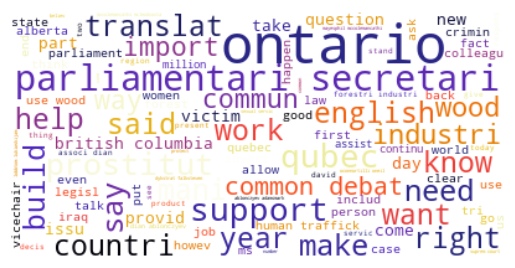

In [18]:
#generate wordcloud from text mining
cloud_text = ' '.join(preprocessed_text)

# Generate the word cloud
wc = WordCloud(background_color='white', colormap = 'CMRmap').generate(cloud_text)

# Display the word cloud
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')  # Turn off the axis
plt.show()

In [19]:
# Initialize data dictionary for structured output
data_gram2 = {'Document': [], 'Dominant Topic': [], 'Topic Keywords': [], 'Unigrams': [], 'Bigrams': [], 'Trigrams': []}

# Iterate over the rows of DataFrame from Part 1
for index, row in df.iterrows():
    preprocessed_text = row['Preprocessed Tokens']
    filename = row['Document']
    dominant_topic = row['Dominant Topic']
    topic_keywords = row['Topic Keywords']
    
    # Join preprocessed tokens into a single string
    preprocessed_text_string = ' '.join(preprocessed_text)

    # Perform n-gram extraction
    ngram_vectorizer = CountVectorizer(analyzer='word', ngram_range=(1, 3))  # Adjust ngram_range as needed
    X = ngram_vectorizer.fit_transform([preprocessed_text_string])
    feature_names = ngram_vectorizer.get_feature_names_out()
    
    # Separate feature names into unigrams, bigrams, and trigrams
    unigrams = [feature for feature in feature_names if len(feature.split()) == 1]
    bigrams = [feature for feature in feature_names if len(feature.split()) == 2]
    trigrams = [feature for feature in feature_names if len(feature.split()) == 3]
    
    data_gram2['Document'].append(filename)
    data_gram2['Dominant Topic'].append(dominant_topic)
    data_gram2['Topic Keywords'].append(topic_keywords)
    data_gram2['Unigrams'].append(', '.join(unigrams))
    data_gram2['Bigrams'].append(', '.join(bigrams))
    data_gram2['Trigrams'].append(', '.join(trigrams))

# Create a DataFrame from the structured data
df_gram2 = pd.DataFrame(data_gram2)
df_gram2.head()

,Document,Dominant Topic,Topic Keywords,Unigrams,Bigrams,Trigrams
0,20170130-HAN129-E.pdf,6,"regard, statist, mani, question, inform, retur...","aa, aandc, aandcinac, aban, abandon, abdic, ab...","aa amount, aandc indigenousand, aandcinac iden...","aa amount iap, aandc indigenousand northern, a..."
1,20200420-HAN034-E.pdf,6,"work, busi, need, help, mani, support, health,...","aaron, aarontuck, abandon, abandonedw, abandon...","aaron tuck, aarontuck greg, abandon parliament...","aaron tuck jolen, aarontuck greg jami, abandon..."
2,20230602-HAN205-E.pdf,2,"point, order, question, mr, assist, deputi, ca...","abil, abilityof, abit, abl, aboard, aboultaif,...","abil better, abil extern, abil feed, abil fina...","abil better review, abil extern depth, abil fe..."
3,20120307-HAN091-E.pdf,4,"job, countri, know, want, debat, last, english...","abandon, abdic, abil, abitibitmiscamingu, abl,...","abandon inshor, abandon veteran, abdic democra...","abandon inshor fisheri, abandon veteran first,..."
4,20131126-HAN024-E.pdf,2,"question, say, duffi, know, parti, ask, talk, ...","aballot, abandon, abdic, abeauti, abet, abett,...","aballot sacrifici, abandon mental, abdic respo...","aballot sacrifici lamb, abandon mental health,..."


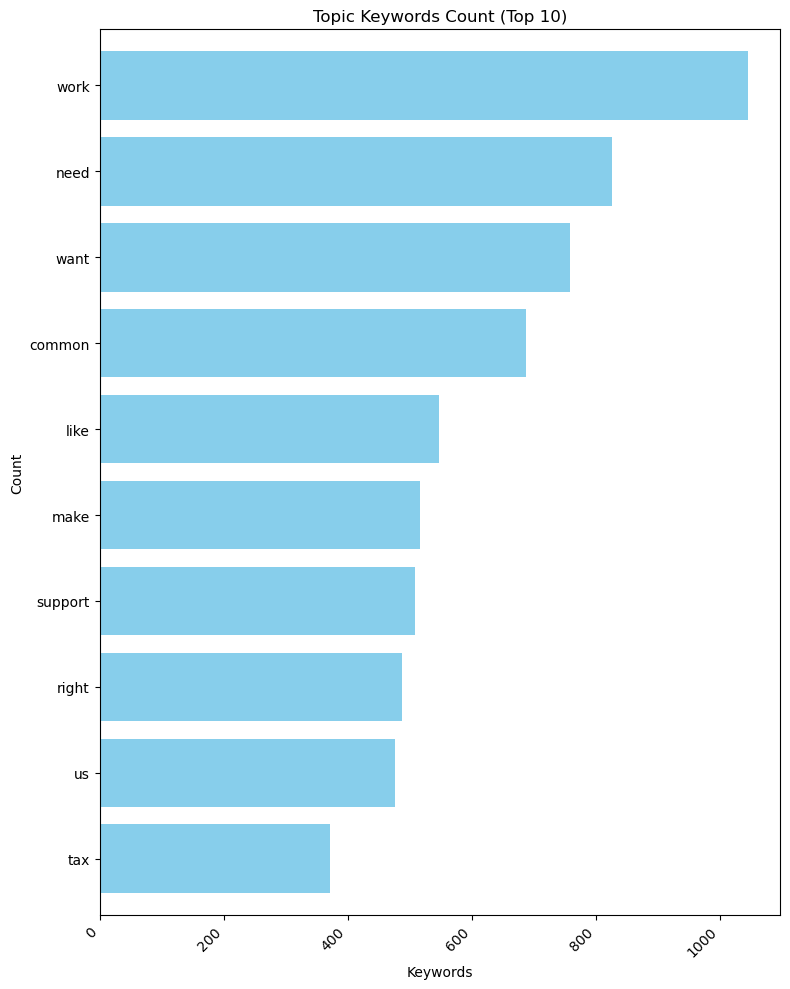

In [20]:
# Topic Keywords count
# Filter Topic Keywords with count >= 100
topic_keyword_counts = df['Topic Keywords'].str.split(', ').explode().value_counts()
topic_keyword_counts_filtered = topic_keyword_counts[topic_keyword_counts >= 20].sort_values(ascending=True)
top_10_values = topic_keyword_counts.head(10).sort_values(ascending=True)
plt.figure(figsize=(8, 10))
top_10_values.plot(kind='barh', color='skyblue', width=0.8)
plt.title('Topic Keywords Count (Top 10)')
plt.xlabel('Keywords')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

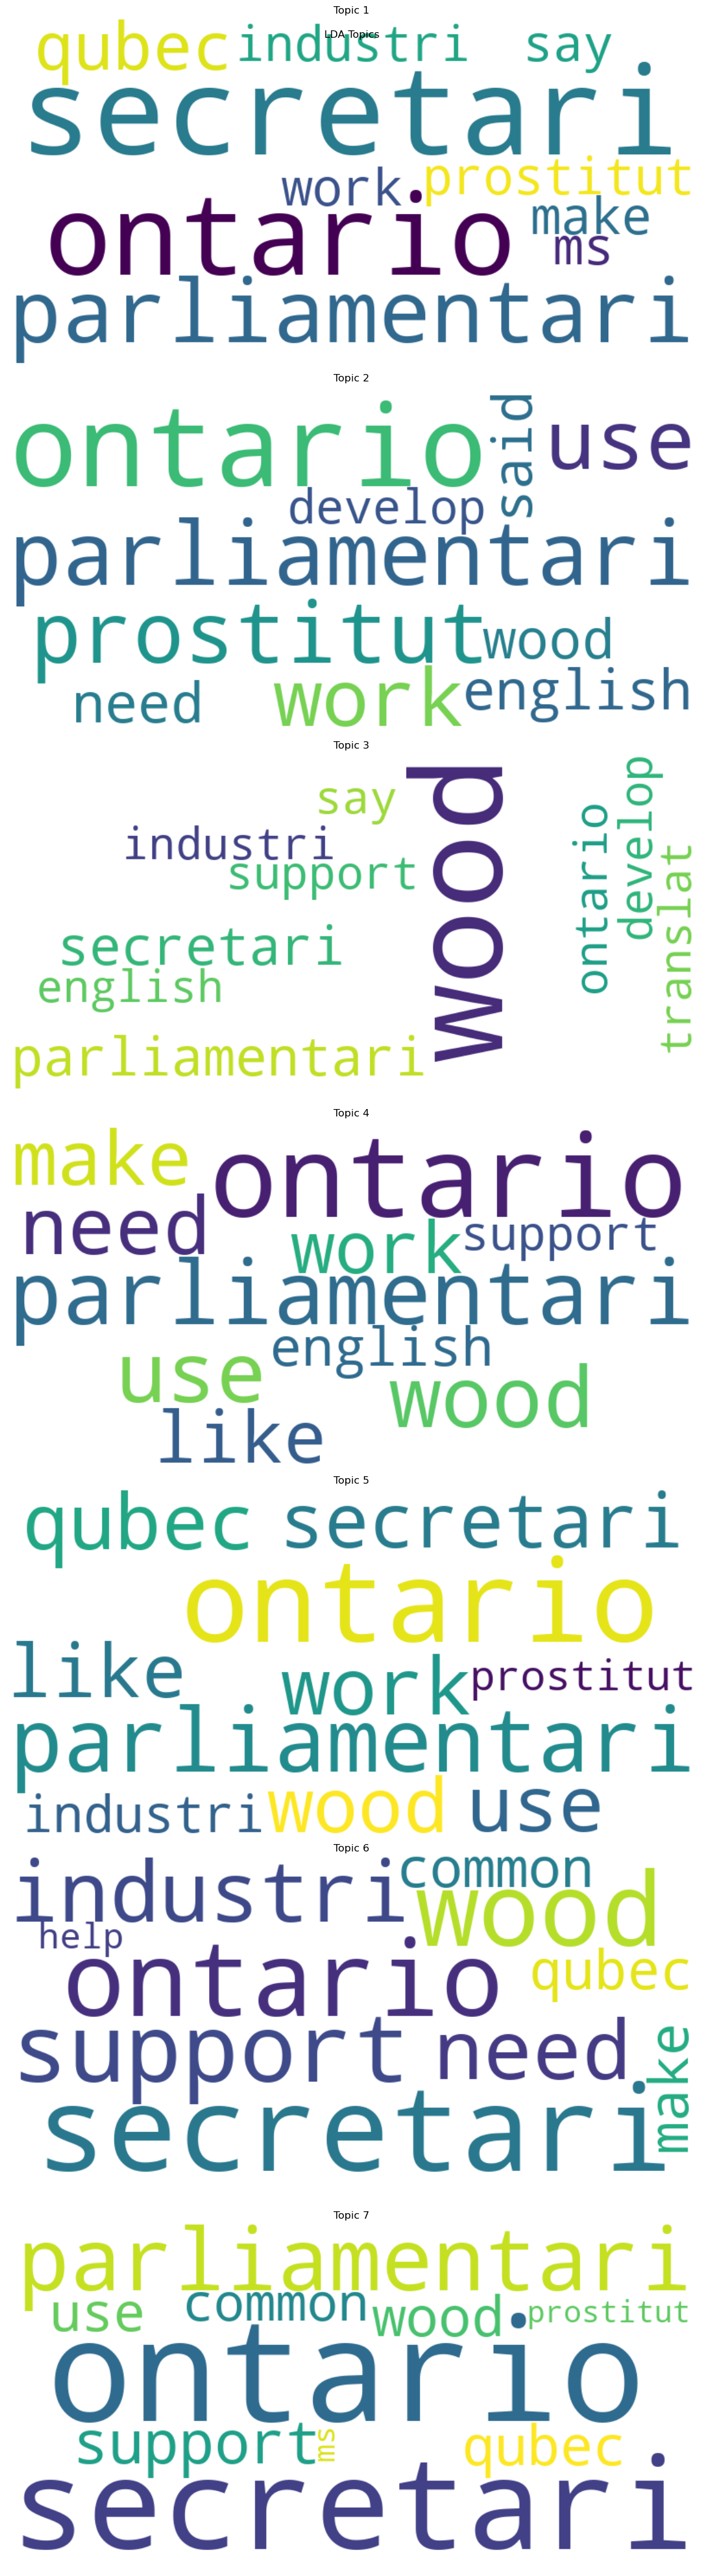

In [21]:
# Load LDA model and get the number of topics
num_topics = lda_model.num_topics

# Create a figure with subplots for each topic
fig, axs = plt.subplots(nrows=num_topics, figsize=(15, 6*num_topics))
fig.suptitle('LDA Topics')

# Generate word cloud for each topic
for i in range(num_topics):
    ax = axs[i]
    lda_topic = lda_model.show_topic(i)
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(dict(lda_topic))
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.set_title('Topic ' + str(i+1))
    ax.axis('off')

plt.tight_layout()
plt.show()


(7, 7525)


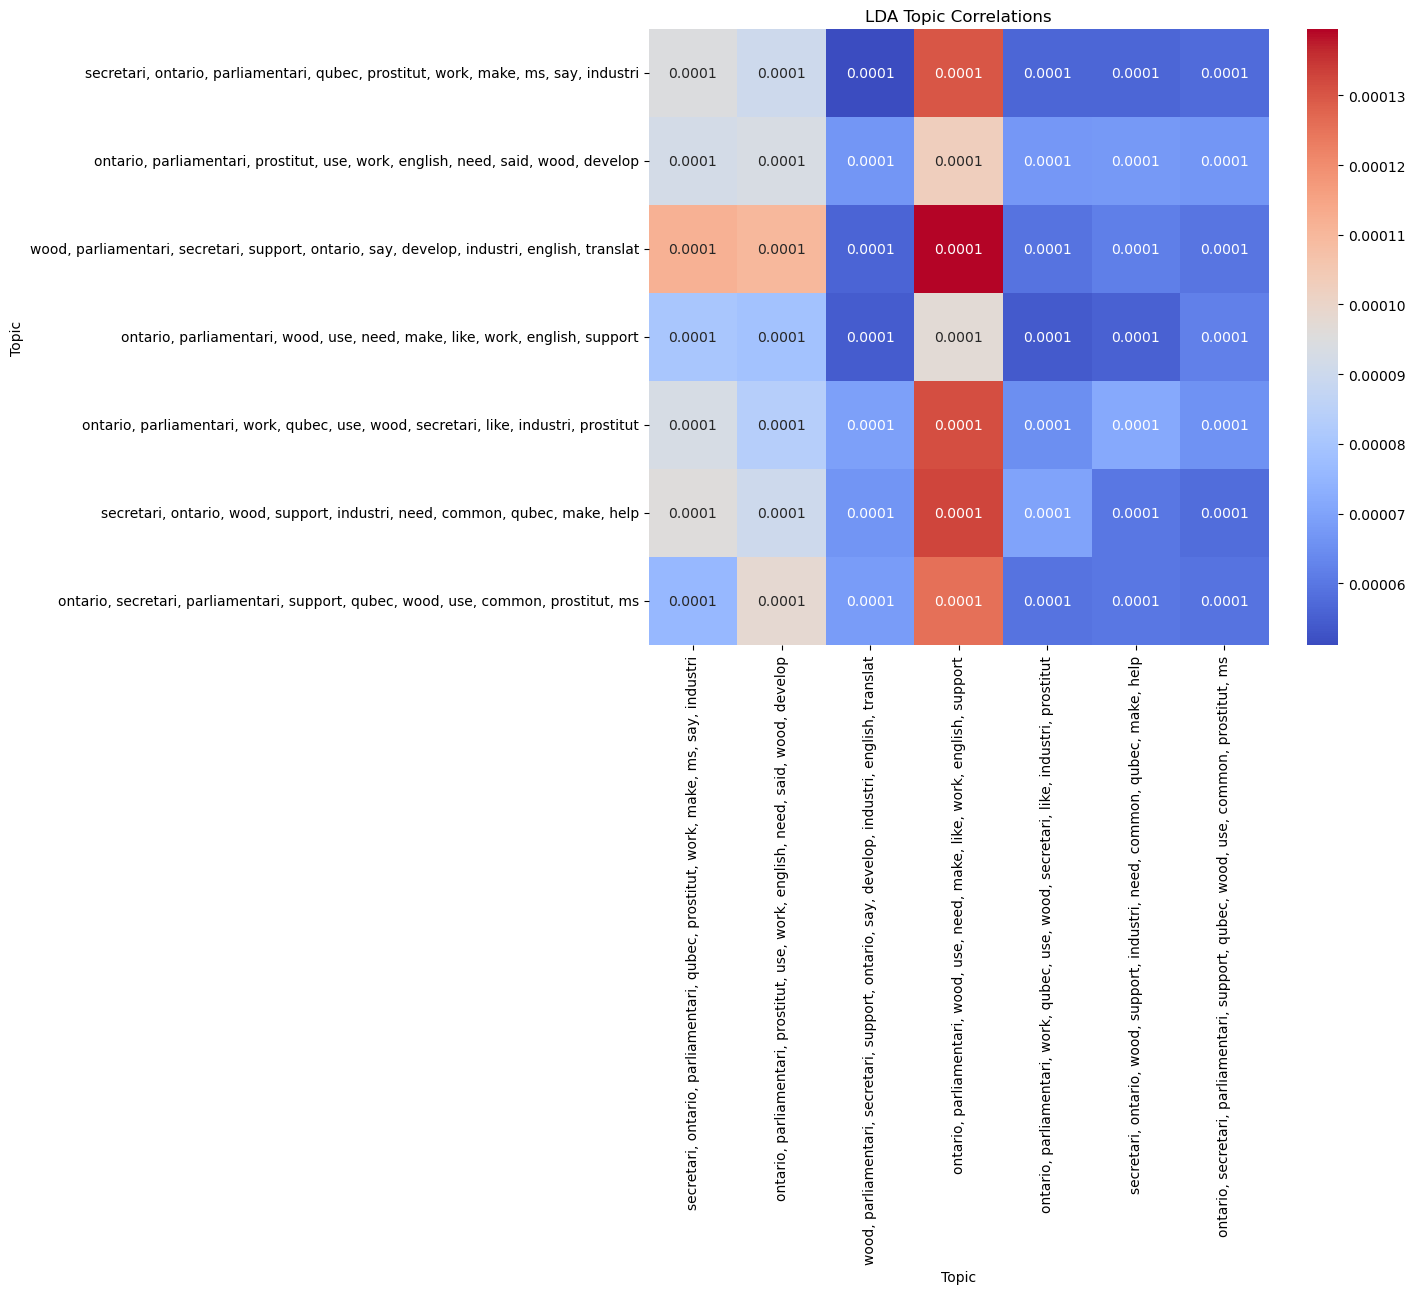

In [22]:
# Assuming lda_model is the trained LDA model
correlation = lda_model.state.get_lambda()
correlation = correlation / correlation.sum(axis=1)[:, None]  # Normalize the matrix
top_words = [', '.join([word for word, _ in lda_model.show_topic(i)]) for i in range(num_topics)]

# Check the shape of the correlation matrix
print(correlation.shape)  # It should be (num_topics, num_words)

# Reshape the correlation matrix if needed
num_topics = correlation.shape[0]
correlation_matrix = correlation[:, :num_topics]  # Take only the topics part

# Plot the heatmap with the correct shape
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".4f", cmap="coolwarm",
            xticklabels=top_words, yticklabels=top_words)
plt.title('LDA Topic Correlations')
plt.xlabel('Topic')
plt.ylabel('Topic')
plt.show()

In [23]:
from random import sample

#Due to large size of dataset, I've chosen a subset of documents:
subset_documents = sample(os.listdir(pdf_directory), 200)

#Setting the range of topics to compare
num_topics_range = range(5, 21)

# Initialize data dictionary for coherence scores
coherence_data = {'Num Topics': [], 'Coherence Score': []}

# Iterate over different numbers of topics
for num_topics in num_topics_range:
    coherence_scores = []
    
    # Iterate over the subset of documents
    for filename in subset_documents:
        if filename.endswith('.pdf'):
            pdf_file = os.path.join(pdf_directory, filename)
            text = extract_text_from_pdf(pdf_file)  
            preprocessed_text = preprocess_text(text)
            lda_model, dictionary = perform_topic_modeling([preprocessed_text], num_topics=num_topics)
            coherence_model_lda = CoherenceModel(model=lda_model, texts=[preprocessed_text], dictionary=dictionary, coherence='c_v')
            coherence_lda = coherence_model_lda.get_coherence()
            coherence_scores.append(coherence_lda)
    
    # Average coherence score
    avg_coherence_score = np.mean(coherence_scores)
    coherence_data['Num Topics'].append(num_topics)
    coherence_data['Coherence Score'].append(avg_coherence_score)

coherence_df = pd.DataFrame(coherence_data)

optimal_num_topics = coherence_df.loc[coherence_df['Coherence Score'].idxmax()]['Num Topics']
print("Optimal Number of Topics:", optimal_num_topics)

Optimal Number of Topics: 5.0


In [24]:
#To run a more efficient code to verify coherence values for the full dataset, a sample is take.
#Note that each time the kernel is rerun, a different values may populate in table than the previous time.

coherence_df

,Num Topics,Coherence Score
0,5,0.321582
1,6,0.321323
2,7,0.321006
3,8,0.321173
4,9,0.320939
5,10,0.320810
6,11,0.320885
7,12,0.320771
8,13,0.320976
9,14,0.321026


In [26]:
df_sub1 = df.copy()

In [27]:
print(df_sub1.head())

                Document       Date Parliament-Session  Original Word Count  \
0  20170130-HAN129-E.pdf 2017-01-30               42-1                94682   
1  20200420-HAN034-E.pdf 2020-04-20               43-1                74492   
2  20230602-HAN205-E.pdf 2023-06-02               44-1                29410   
3  20120307-HAN091-E.pdf 2012-03-07               41-1                31265   
4  20131126-HAN024-E.pdf 2013-11-26               41-2                75148   

   Final Word Count  Topic Coherence  Dominant Topic Dominant Topic Value  \
0             42004         0.255357               6                 date   
1             35285         0.269678               6               health   
2             14065         0.391428               2             question   
3             12533         0.275311               4                debat   
4             30271         0.361315               2                duffi   

                                      Topic Keywords Topic Key

In [28]:
df_sub1['Year'] = df_sub1['Date'].dt.year

In [35]:
parliament_session_counts = df_sub1['Parliament-Session'].value_counts().sort_index()
year_counts = df_sub1['Year'].value_counts().sort_index()
parliament_session_mean = parliament_session_counts.mean()
year_counts_mean = year_counts.mean()

In [36]:
plt.figure(figsize=(12, 5))

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

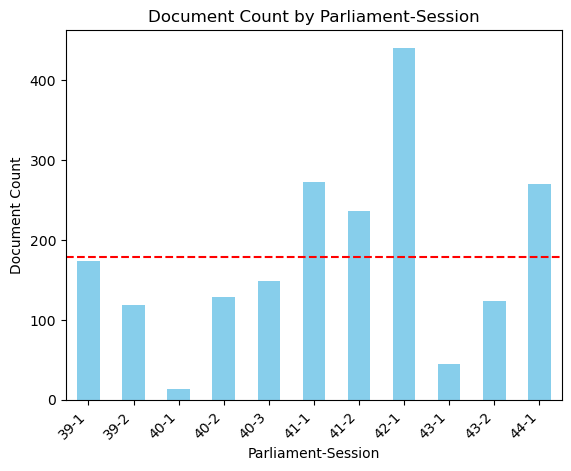

In [37]:
#Total Documents by Parliment-Session
parliament_session_counts.plot(kind='bar', color='skyblue')
plt.axhline(y=parliament_session_mean, color='red', linestyle='--', label='Mean')
plt.title('Document Count by Parliament-Session')
plt.xlabel('Parliament-Session')
plt.ylabel('Document Count')
plt.xticks(rotation=45, ha='right')
plt.show()

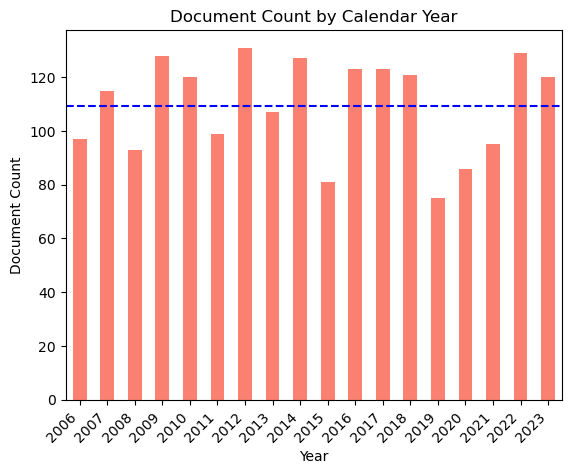

In [38]:
#Total Documents by Calendar Year
year_counts.plot(kind='bar', color='salmon')
plt.axhline(y=year_counts_mean, color='blue', linestyle='--', label='Mean')
plt.title('Document Count by Calendar Year')
plt.xlabel('Year')
plt.ylabel('Document Count')
plt.xticks(rotation=45, ha='right')
plt.show()